### Pendeteksi Kebakaran menggunakan CNN

1. Instal depedensi yang dibutuhkan

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                         Version
------------------------------- -----------
absl-py                         1.3.0
aiohttp                         3.8.1
aiosignal                       1.3.1
anaconda-client                 1.11.0
anaconda-navigator              2.3.2
anyio                           3.5.0
argon2-cffi                     21.3.0
argon2-cffi-bindings            21.2.0
asttokens                       2.0.5
astunparse                      1.6.3
async-generator                 1.10
async-timeout                   4.0.2
attrs                           21.4.0
Babel                           2.9.1
backcall                        0.2.0
backports.functools-lru-cache   1.6.4
backports.tempfile              1.0
backports.weakref               1.0.post1
beautifulsoup4                  4.11.1
bitstring                       3.1.9
bleach                          4.1.0
blinker                         1.5
blis                            0.7.9
Bottleneck                      1.3.5


Import library yang akan diguanakan

In [3]:
import tensorflow as tf
import os

d:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


setup GPU untuk training

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

### 2. Data Cleaning

import library yang digunankan

In [6]:
import cv2
import imghdr

mengambil dataset

In [7]:
data_dir = 'data' 

format dataset yang digunakan

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

membaca data gambar sesuai format, dan menghapus gambar yang tidak terbaaca

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Gambar tidak berada pada dataset {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Gambar bermasalah {}'.format(image_path))

### Mempersiapkan model data Training

import library yang dibutuhkan

In [10]:
import numpy as np
from matplotlib import pyplot as plt

membaca data berdasarkan folder

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 977 files belonging to 2 classes.


transformasi data kedalam matriks

In [12]:
data_iterator = data.as_numpy_iterator()

Data disimpan dalam bentuk batch matriks

In [13]:
batch = data_iterator.next()

kita bisa melihat data pada batch matriks sebagai berikut

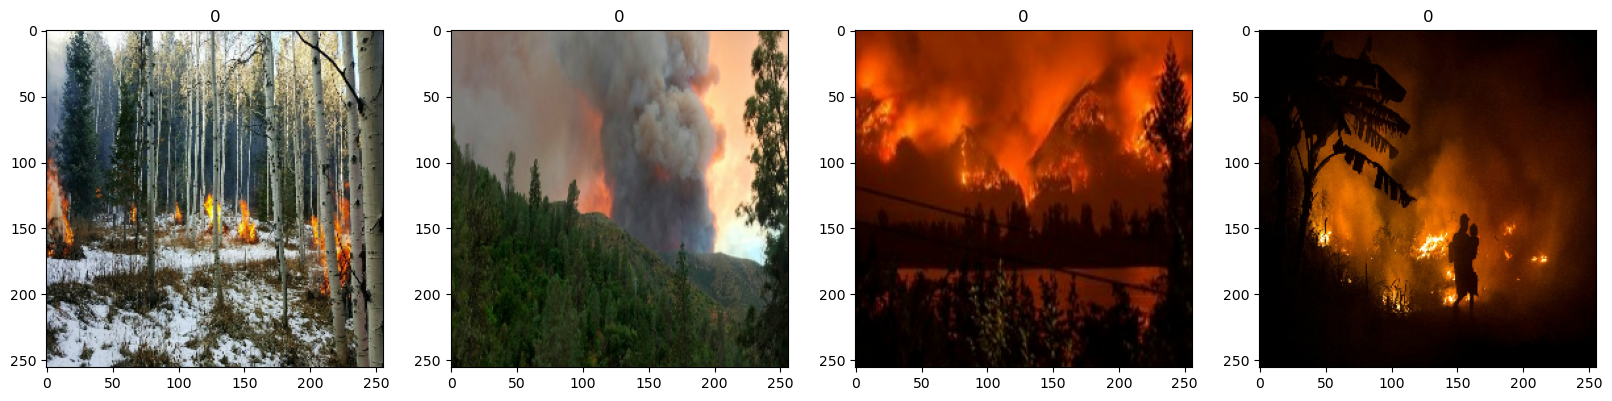

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Transformasi data

data gambar berupa matriks akan diubah kedalam dengan skala 255 bit. x untuk file gambar dan y untuk label gambar (1/0) (1 : tidak ada kebakaran, 0 : ada kebakaran)

In [15]:
data = data.map(lambda x,y: (x/255, y))

Data yang telah diseragamkan (scaling), diubah kedalam bentuk matriks

In [16]:
data.as_numpy_iterator().next()

(array([[[[5.78339458e-01, 2.76378691e-01, 5.67708351e-02],
          [5.95231831e-01, 2.85860896e-01, 6.62530661e-02],
          [6.06792986e-01, 2.89867580e-01, 7.38204643e-02],
          ...,
          [3.80392164e-01, 1.72549024e-01, 7.84313772e-03],
          [3.65100086e-01, 1.72351912e-01, 1.17647061e-02],
          [3.74417901e-01, 1.70496330e-01, 1.36335781e-02]],
 
         [[5.89250386e-01, 2.84037977e-01, 6.44301474e-02],
          [5.99270821e-01, 2.86452234e-01, 6.83517158e-02],
          [6.05310440e-01, 2.87663370e-01, 7.19770864e-02],
          ...,
          [3.78155649e-01, 1.78155631e-01, 1.68504904e-03],
          [3.85447294e-01, 1.79840684e-01, 1.96078438e-02],
          [3.82077217e-01, 1.79840684e-01, 1.79227944e-02]],
 
         [[6.00000024e-01, 2.90196091e-01, 7.05882385e-02],
          [6.09186053e-01, 2.91538984e-01, 7.58526996e-02],
          [6.14077806e-01, 2.89438516e-01, 7.72483647e-02],
          ...,
          [3.88817400e-01, 1.87316179e-01, 7.8431

### Spliting data

data akan dibagi menjadi 2 buah bagian, 70% untuk training, 20% untuk validasi, dan 10% untuk testing

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

dalam dataset ini , sebanyak 21 batch digunakn untuk training, 6 untuk validasi, dan 3 untuk pengujian

In [18]:
print(train_size, val_size, test_size)

21 6 3


value dari data tersebut disimpan untuk proses building machine learning

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Building ML

kita akan menggunakan CNN model skuensial dengan depedensi library sebagai berikut

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model sekuensial dipilih untuk melakukan iterasi secara berurutan , hal ini sesusai dengan perpindahan layer pada CNN

In [21]:
model = Sequential()

selanjutnya data akan diteraining pada 3 layer Relu untuk mendapatkan fully connected layer. aktifasi sigmoid digunakan karena rentang nilai berkisar dari 1-0 (2 class : kebakaran dan tidak kebakaran)

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

menggunaan model adam untuk melihat dan meningkatkan akurasi matriks 

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model CNN yang akan di training adalah sebagai berikut

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### Training model

log digunakn untuk melihat nilai error dan nilai ekurasi setiap epoch (train iterasi)

In [25]:
logdir='logs'

memanggil fungsi training callbacks

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

fungsi digunkan untuk iterasi data sebanyak 20 epoksi

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
21/21 [==============================] - 28s 1s/step - loss: 0.4571 - accuracy: 0.8348 - val_loss: 0.7610 - val_accuracy: 0.7917
Epoch 2/20
21/21 [==============================] - 29s 1s/step - loss: 0.2338 - accuracy: 0.9107 - val_loss: 0.2269 - val_accuracy: 0.9479
Epoch 3/20
21/21 [==============================] - 25s 1s/step - loss: 0.1328 - accuracy: 0.9524 - val_loss: 0.2062 - val_accuracy: 0.9427
Epoch 4/20
21/21 [==============================] - 27s 1s/step - loss: 0.1015 - accuracy: 0.9702 - val_loss: 0.0973 - val_accuracy: 0.9740
Epoch 5/20
21/21 [==============================] - 26s 1s/step - loss: 0.0909 - accuracy: 0.9747 - val_loss: 0.1779 - val_accuracy: 0.9688
Epoch 6/20
21/21 [==============================] - 24s 1s/step - loss: 0.0928 - accuracy: 0.9688 - val_loss: 0.1086 - val_accuracy: 0.9583
Epoch 7/20
21/21 [==============================] - 24s 1s/step - loss: 0.0567 - accuracy: 0.9792 - val_loss: 0.0525 - val_accuracy: 0.9792
Epoch 8/20
21/21 [==

### Pengukuran akurasi

Hasil 20 iterasi menurunkan tingkat error secara bertahap

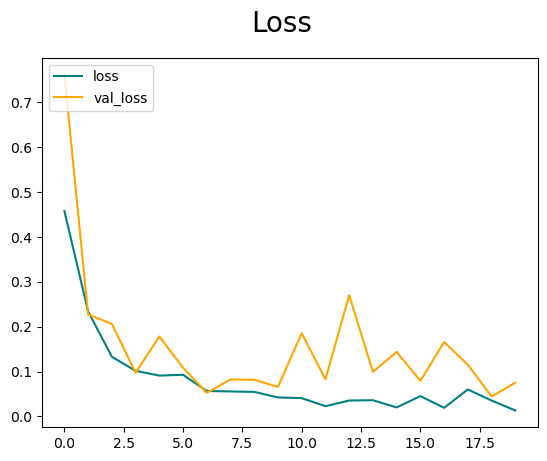

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Nilai akurasi berbanding terbalik dari nilai error

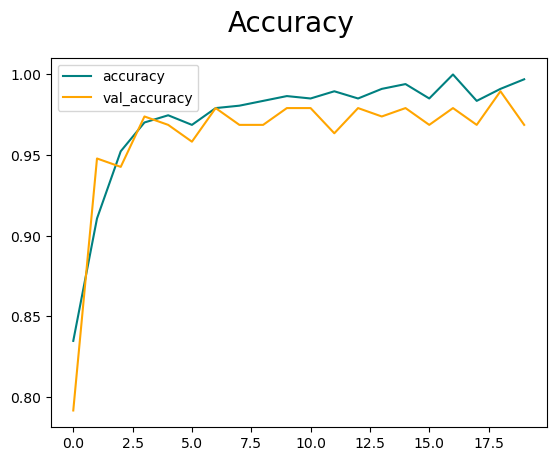

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluasi

evaluasi dilakukan menggunakan precision dan recall, serta akurasi

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

memanggil fungsi 

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

melakukan evaluasi dari data testing 

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 180ms/step


hasil presisi, recall, dan akurasi dari model

In [33]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.95238096, shape=(), dtype=float32) tf.Tensor(0.9895833, shape=(), dtype=float32)


# 10. Testing 

mengimport libary yang dibutuhkan

In [34]:
import cv2

Memuat gambar

test1.jpeg : test hutan kebakaran <br>test2.jpeg : hutan tidak kebakaran

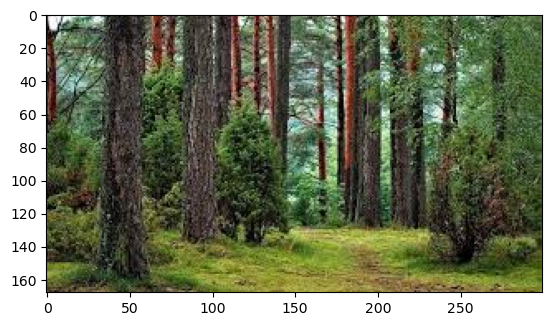

In [40]:
img = cv2.imread('test2.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

transformasi dimensi gambar agar sesuai dengann model

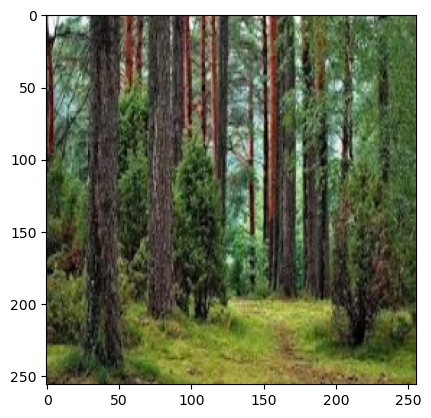

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

memanggil model prediski untuk data testing

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 26ms/step


hasil dari pengujian

In [43]:
yhat

array([[0.99285924]], dtype=float32)

mengindikasi bahwa kondisi hutan

In [44]:
if yhat > 0.5: 
    print(f'Tidak ada kebakaran')
else:
    print(f'Kebakaran')

Tidak ada kebakaran


Semakin tinggi nilai epoksi , semakin besar akurasi yang dimiliki model untuk setiap iterasi berikutnya